In [48]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [49]:
file_path = '../data_processed/merged_workout_metrics.csv'
workouts = pd.read_csv(file_path)
# Transform the 'Gender' column into two separate columns
workouts = pd.get_dummies(workouts, columns=['Gender'])
workouts['Gender_M'] = workouts['Gender_M'].astype(int)
workouts['Gender_F'] = workouts['Gender_F'].astype(int)

# convert duration to minutes
# List of duration columns to be transformed
duration_columns = [
    'total_workout_duration', 'total_cardio_duration', 'total_isotonic_duration',
    'duration_core', 'duration_lower_body', 'duration_total_body', 'duration_upper_body',
    'duration_cardiovascular', 'duration_flexibility_mobility', 'duration_free_weights',
    'duration_functional_training', 'duration_strength_training'
]

# Transform the duration columns from seconds to minutes
workouts[duration_columns] = workouts[duration_columns] / 60

print(workouts.shape)
workouts.head()

(439696, 22)


,CloudId,Date,WorkoutId,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,...,duration_upper_body,duration_cardiovascular,duration_flexibility_mobility,duration_free_weights,duration_functional_training,duration_strength_training,Intensity,Age,Gender_F,Gender_M
0,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2022-01-15,0015d65e3205deb6bb6a8f0d57cc48547918f0f22022-0...,57.283333,485.0,180.0,12.333333,305.0,44.950000,5.1,...,29.716667,12.333333,0.0,21.9,0.0,23.050000,0.141111,56,0,1
1,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2022-01-31,0015d65e3205deb6bb6a8f0d57cc48547918f0f22022-0...,70.033333,562.0,280.0,28.000000,282.0,42.033333,5.1,...,25.666667,28.000000,0.0,21.9,0.0,20.133333,0.133746,56,0,1
2,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2022-02-02,0015d65e3205deb6bb6a8f0d57cc48547918f0f22022-0...,66.433333,537.0,255.0,25.000000,282.0,41.433333,5.1,...,25.750000,25.000000,0.0,21.9,0.0,19.533333,0.134722,56,0,1
3,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2022-02-05,0015d65e3205deb6bb6a8f0d57cc48547918f0f22022-0...,64.383333,497.0,215.0,22.083333,282.0,42.300000,5.1,...,25.850000,22.083333,0.0,21.9,0.0,20.400000,0.128656,56,0,1
4,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,2022-02-07,0015d65e3205deb6bb6a8f0d57cc48547918f0f22022-0...,72.900000,569.0,287.0,24.000000,282.0,48.900000,5.1,...,27.000000,24.000000,0.0,21.9,0.0,27.000000,0.130087,56,0,1


After that, we have two options:
- Cluster workouts as they are and create broader categories
- Perform further aggregations and then cluster the users directly

#### How many workouts that have a duration more than 4 hours?

In [50]:
# Filter workouts with duration more than 4 hours (240 minutes)
long_workouts = workouts[workouts['total_workout_duration'] > 240]
print(f"Number of workouts with duration more than 4 hours: {long_workouts.shape[0]}")

# Count the number of distinct users who performed these workouts
num_distinct_users = long_workouts['CloudId'].nunique()
print(f"Number of distinct users who performed workouts with duration more than 4 hours: {num_distinct_users}")

# Get the list of users who performed a workout more than 4 hours
users_to_remove = long_workouts['CloudId'].unique()
workouts_filtered = workouts[~workouts['CloudId'].isin(users_to_remove)]
workouts_cleaned = workouts_filtered.copy()
print(workouts_cleaned.shape)

Number of workouts with duration more than 4 hours: 1202
Number of distinct users who performed workouts with duration more than 4 hours: 130
(423384, 22)


In [51]:
# # Define numerical features
# numerical_features = [col for col in workouts.columns if workouts[col].dtype in ['int64', 'float64']]

# # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numerical feature
# Q1 = workouts[numerical_features].quantile(0.05)
# Q3 = workouts[numerical_features].quantile(0.95)
# IQR = Q3 - Q1

# # Define a mask to filter out outliers
# mask = ~((workouts[numerical_features] < (Q1 - 1.5 * IQR)) | (workouts[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)

# # Apply the mask to the DataFrame
# workouts_cleaned = workouts[mask]

# # Display the first few rows of the cleaned DataFrame
# workouts_cleaned.head()

## Keep only men

In [52]:
# Include only male users
workouts_m = workouts_cleaned[workouts_cleaned['Gender_M'] == 1]
# drop gender columns
workouts_m = workouts_m.drop(['Gender_F', 'Gender_M'], axis=1)
workouts_cleaned = workouts_m.copy()

### Create durations ratio columns

In [53]:
# Select the columns for clustering
features = ['total_workout_duration', 'total_calories_burnt', 'total_cardio_calories',
            'total_cardio_duration', 'total_isotonic_calories', 'total_isotonic_duration',
            'duration_core', 'duration_lower_body', 'duration_total_body', 'duration_upper_body',
            'duration_cardiovascular', 'duration_flexibility_mobility', 'duration_free_weights',
            'duration_functional_training', 'duration_strength_training', 'Intensity']

workouts_cleaned = workouts_cleaned[features]

In [54]:
# Calculate the ratio of each duration to the total duration
duration_columns = [
    'total_cardio_duration', 'total_isotonic_duration', 'duration_core', 'duration_lower_body',
    'duration_total_body', 'duration_upper_body', 'duration_cardiovascular', 'duration_flexibility_mobility',
    'duration_free_weights', 'duration_functional_training', 'duration_strength_training'
]

X = workouts_cleaned.copy()

for col in duration_columns:
    X[f'{col}_ratio'] = X[col] / X['total_workout_duration']

# Add these new features to the list of features
features = [
    'total_workout_duration', 'total_calories_burnt', 'total_cardio_calories', 'total_cardio_duration',
    'total_isotonic_calories', 'total_isotonic_duration', 'duration_core', 'duration_lower_body',
    'duration_total_body', 'duration_upper_body', 'duration_cardiovascular', 'duration_flexibility_mobility',
    'duration_free_weights', 'duration_functional_training', 'duration_strength_training', 'Intensity'
] + [f'{col}_ratio' for col in duration_columns]

# Select the features from the DataFrame
workouts_cleaned = X[features]
poly_df = workouts_cleaned.copy()

# # Initialize PolynomialFeatures with the desired degree
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # Generate polynomial features
# poly_features = poly.fit_transform(aug_df)

# # Create a DataFrame with the polynomial features
# poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(aug_df.columns))

print("Polynomial Features DataFrame:")
poly_df.head()

Polynomial Features DataFrame:


,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,duration_lower_body,duration_total_body,duration_upper_body,...,total_isotonic_duration_ratio,duration_core_ratio,duration_lower_body_ratio,duration_total_body_ratio,duration_upper_body_ratio,duration_cardiovascular_ratio,duration_flexibility_mobility_ratio,duration_free_weights_ratio,duration_functional_training_ratio,duration_strength_training_ratio
0,57.283333,485.0,180.0,12.333333,305.0,44.950000,5.1,10.133333,12.333333,29.716667,...,0.784696,0.089031,0.176898,0.215304,0.518766,0.215304,0.0,0.382310,0.0,0.402386
1,70.033333,562.0,280.0,28.000000,282.0,42.033333,5.1,24.266667,15.000000,25.666667,...,0.600190,0.072822,0.346502,0.214184,0.366492,0.399810,0.0,0.312708,0.0,0.287482
2,66.433333,537.0,255.0,25.000000,282.0,41.433333,5.1,20.583333,15.000000,25.750000,...,0.623683,0.076769,0.309834,0.225790,0.387607,0.376317,0.0,0.329654,0.0,0.294029
3,64.383333,497.0,215.0,22.083333,282.0,42.300000,5.1,21.350000,12.083333,25.850000,...,0.657002,0.079213,0.331608,0.187678,0.401501,0.342998,0.0,0.340150,0.0,0.316852
4,72.900000,569.0,287.0,24.000000,282.0,48.900000,5.1,16.800000,24.000000,27.000000,...,0.670782,0.069959,0.230453,0.329218,0.370370,0.329218,0.0,0.300412,0.0,0.370370


In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(poly_df)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
workouts_cleaned['Cluster'] = kmeans.fit_predict(X)

# Display the first few rows with the cluster assignments
workouts_cleaned.head()

,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,duration_lower_body,duration_total_body,duration_upper_body,...,duration_core_ratio,duration_lower_body_ratio,duration_total_body_ratio,duration_upper_body_ratio,duration_cardiovascular_ratio,duration_flexibility_mobility_ratio,duration_free_weights_ratio,duration_functional_training_ratio,duration_strength_training_ratio,Cluster
0,57.283333,485.0,180.0,12.333333,305.0,44.950000,5.1,10.133333,12.333333,29.716667,...,0.089031,0.176898,0.215304,0.518766,0.215304,0.0,0.382310,0.0,0.402386,3
1,70.033333,562.0,280.0,28.000000,282.0,42.033333,5.1,24.266667,15.000000,25.666667,...,0.072822,0.346502,0.214184,0.366492,0.399810,0.0,0.312708,0.0,0.287482,1
2,66.433333,537.0,255.0,25.000000,282.0,41.433333,5.1,20.583333,15.000000,25.750000,...,0.076769,0.309834,0.225790,0.387607,0.376317,0.0,0.329654,0.0,0.294029,1
3,64.383333,497.0,215.0,22.083333,282.0,42.300000,5.1,21.350000,12.083333,25.850000,...,0.079213,0.331608,0.187678,0.401501,0.342998,0.0,0.340150,0.0,0.316852,1
4,72.900000,569.0,287.0,24.000000,282.0,48.900000,5.1,16.800000,24.000000,27.000000,...,0.069959,0.230453,0.329218,0.370370,0.329218,0.0,0.300412,0.0,0.370370,1


In [65]:
# Group by 'Cluster' and calculate the mean for each group, keeping only numerical features
numerical_features = [col for col in workouts_cleaned.columns if workouts_cleaned[col].dtype in ['int64', 'float64']]

cluster_means = workouts_cleaned.groupby('Cluster')[features].mean()

# Add the count of records in each cluster
cluster_counts = workouts_cleaned['Cluster'].value_counts().sort_index()
cluster_means['Count'] = cluster_counts

# Display the average column values for each cluster along with the count
cluster_means

,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,duration_lower_body,duration_total_body,duration_upper_body,...,duration_core_ratio,duration_lower_body_ratio,duration_total_body_ratio,duration_upper_body_ratio,duration_cardiovascular_ratio,duration_flexibility_mobility_ratio,duration_free_weights_ratio,duration_functional_training_ratio,duration_strength_training_ratio,Count
Cluster,,,,,,,,,,,,,,,,,,,,,
0,28.618845,197.466558,61.552282,7.613543,135.914276,21.005301,3.145279,11.963320,3.461550,10.048696,...,0.111892,0.403912,0.105491,0.378705,0.206423,0.001736,0.023828,0.047037,0.720976,57802
1,71.918823,522.836128,297.611596,35.983067,225.224532,35.935756,6.855059,31.017073,18.012660,16.034031,...,0.093848,0.433728,0.254063,0.218361,0.485203,0.003284,0.030527,0.054617,0.426369,45499
2,26.753642,222.433124,204.778691,24.088145,17.654433,2.665497,0.504429,11.471443,13.327971,1.449800,...,0.013896,0.423007,0.520278,0.042819,0.917612,0.001561,0.003364,0.006717,0.070746,68525
3,57.580592,278.794096,65.368195,6.717031,213.425901,50.863561,2.856871,8.909918,5.898096,39.915706,...,0.044989,0.150173,0.091931,0.712907,0.100328,0.005464,0.480977,0.175128,0.238102,28455
4,72.891952,431.394228,120.597674,12.534795,310.796554,60.357157,17.820442,17.638454,11.383050,26.050005,...,0.272123,0.233669,0.157125,0.337083,0.150281,0.073086,0.103287,0.373318,0.300027,18398
5,70.372827,697.485132,648.863374,63.268489,48.621758,7.104339,1.532443,27.743438,37.834596,3.262350,...,0.018033,0.383104,0.560338,0.038525,0.909331,0.002344,0.004441,0.010145,0.073739,30536


In [67]:
# Normalize the features
cluster_means_scaled = pd.DataFrame(cluster_means/cluster_means.max(), columns=cluster_means.columns)


In [68]:
cluster_means_scaled

,total_workout_duration,total_calories_burnt,total_cardio_calories,total_cardio_duration,total_isotonic_calories,total_isotonic_duration,duration_core,duration_lower_body,duration_total_body,duration_upper_body,...,duration_core_ratio,duration_lower_body_ratio,duration_total_body_ratio,duration_upper_body_ratio,duration_cardiovascular_ratio,duration_flexibility_mobility_ratio,duration_free_weights_ratio,duration_functional_training_ratio,duration_strength_training_ratio,Count
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.392620,0.283112,0.094862,0.120337,0.437309,0.348017,0.176498,0.385701,0.091492,0.251748,...,0.411181,0.931256,0.188263,0.531213,0.224957,0.023756,0.049541,0.125996,1.000000,0.843517
1,0.986650,0.749602,0.458666,0.568736,0.724669,0.595385,0.384674,1.000000,0.476090,0.401697,...,0.344874,1.000000,0.453410,0.306297,0.528768,0.044935,0.063468,0.146303,0.591377,0.663977
2,0.367031,0.318907,0.315596,0.380729,0.056804,0.044162,0.028306,0.369843,0.352269,0.036322,...,0.051067,0.975281,0.928508,0.060062,1.000000,0.021364,0.006994,0.017992,0.098126,1.000000
3,0.789944,0.399713,0.100743,0.106167,0.686706,0.842710,0.160314,0.287259,0.155892,1.000000,...,0.165327,0.346237,0.164063,1.000000,0.109336,0.074764,1.000000,0.469112,0.330250,0.415250
4,1.000000,0.618500,0.185860,0.198121,1.000000,1.000000,1.000000,0.568669,0.300864,0.652625,...,1.000000,0.538746,0.280411,0.472829,0.163775,1.000000,0.214744,1.000000,0.416140,0.268486
5,0.965440,1.000000,1.000000,1.000000,0.156442,0.117705,0.085994,0.894457,1.000000,0.081731,...,0.066268,0.883281,1.000000,0.054039,0.990975,0.032069,0.009234,0.027175,0.102277,0.445618


<Figure size 2000x1000 with 0 Axes>

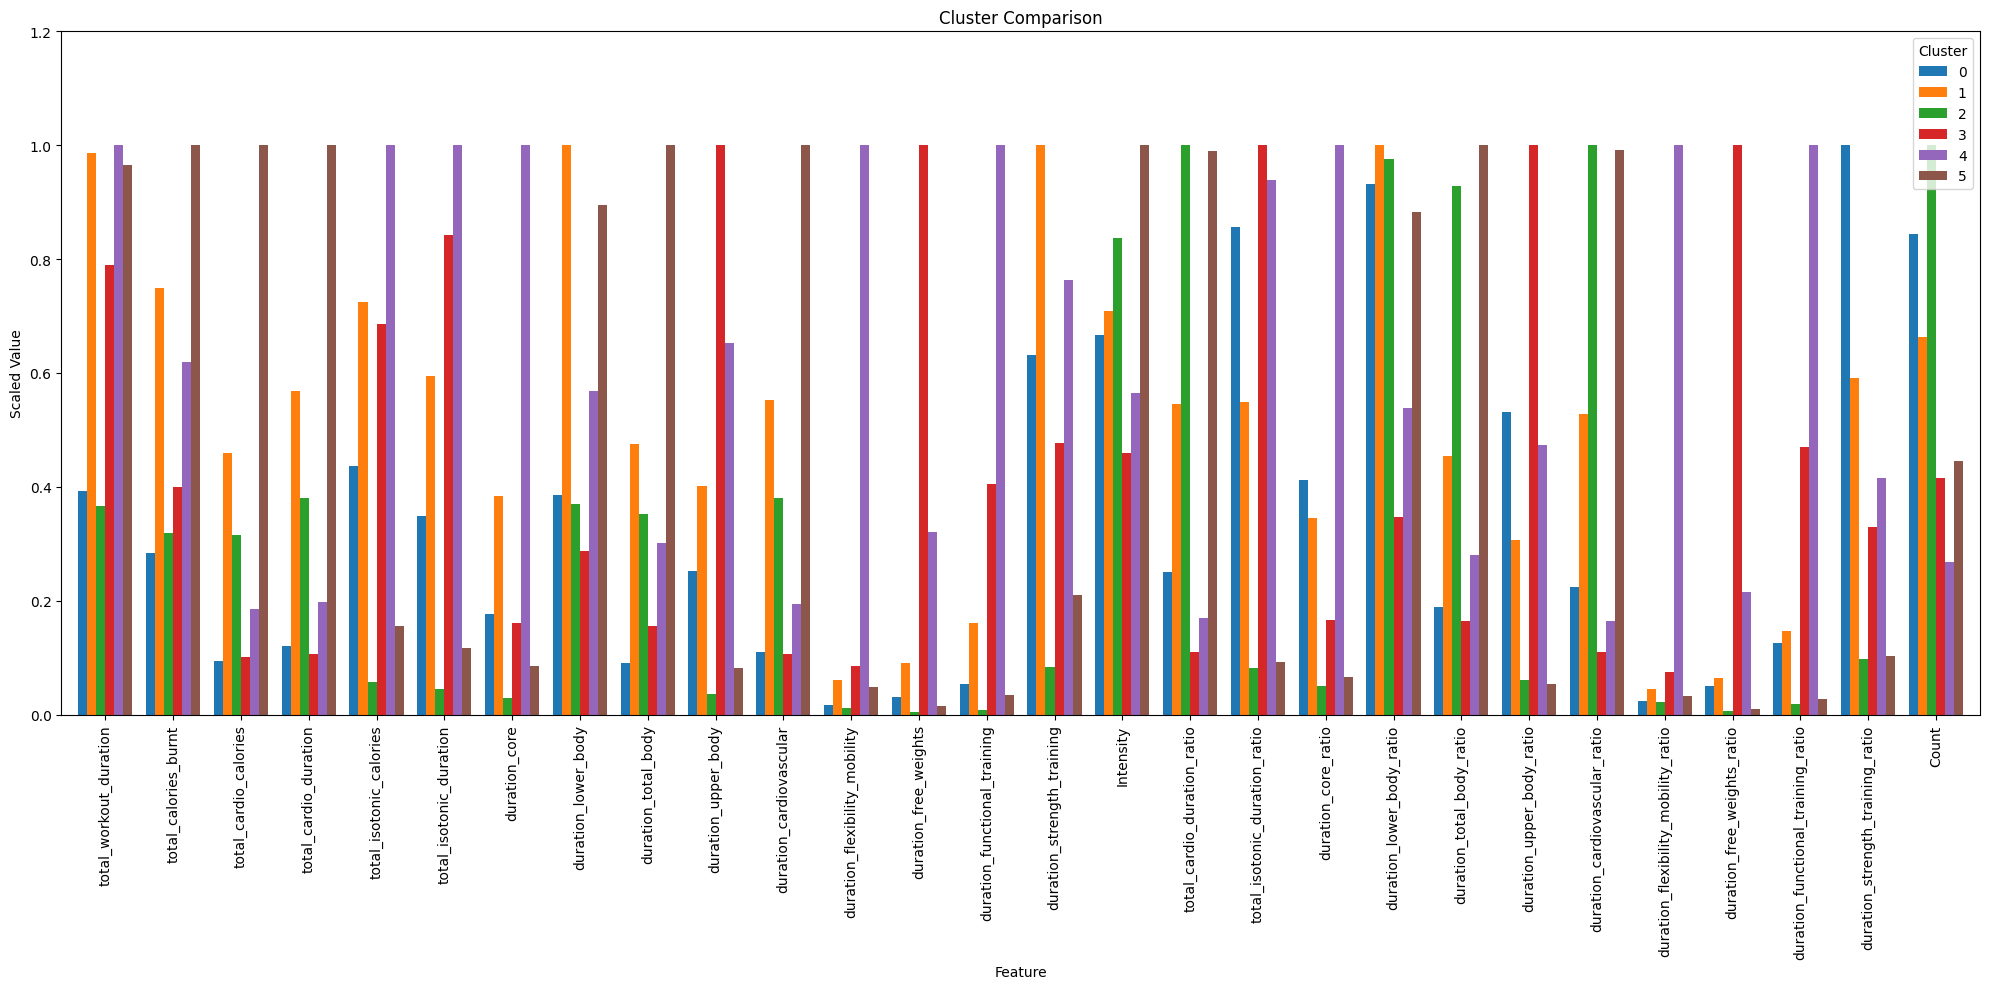

In [69]:
# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the scaled means for each cluster side by side
cluster_means_scaled.T.plot(kind='bar', figsize=(20, 10), width=0.8)
plt.title('Cluster Comparison')
plt.xticks(rotation=90)
plt.ylim(0, 1.2)  # Set the same scale for each cluster
plt.ylabel('Scaled Value')
plt.xlabel('Feature')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [63]:
workouts_cleaned['CloudId'] = workouts_m['CloudId'].values
workouts_cleaned['Date'] = workouts_m['Date'].values

In [64]:
# drop workoutid column
# workouts_cleaned = poly_df.drop(['WorkoutId'], axis=1)
# store to pickle file
workouts_cleaned.to_pickle('workouts_clustered.pkl')